# Retrieve and Parse Model Responses

In [580]:
import json
file_path = 'results_metadata.json'
with open(file_path, 'r') as file:
    # Load the JSON data from the file into a Python dictionary
    metadata = json.load(file)

metadata

{'boolq_valid': {'fields': ['Reasoning', 'Answer', 'Confidence'],
  'models': {'gpt-4o': {'file_id': 'file-12Pr3mz95PN2sGpZnCioLh',
    'batch_id': 'batch_6882b9e8c0b88190a6078d1259b0bbac',
    'output_filename': 'boolq_valid_gpt-4o.json',
    'old_batch': 'batch_68885a713de48190b5c616795507d7f4'},
   'claude-3-haiku-20240307': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_01Eik9sN8Ek6cBd9haYdQoD9',
    'output_filename': 'boolq_valid_claude-3-haiku-20240307.jsonl'},
   'gemini-2.5-pro': {'file_id': 'none',
    'batch_id': 'batches/40v60ylnpg26z17kst8c2tjbpb5lmrhn9rrf',
    'output_filename': 'boolq_valid_gemini-2.5-pro.json'},
   'claude-3-7-sonnet-20250219': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_012oL94fp2HXhvcxAq4Z1BqR',
    'output_filename': 'boolq_valid_claude-3-7-sonnet-20250219.jsonl'},
   'gemini-2.5-flash': {'file_id': 'none',
    'batch_id': 'batches/b6oo1vivedngmdlk1ahnluu326o9x81b9vci',
    'output_filename': 'boolq_valid_gemini-2.5-flash.json'},
   '

# Retrieve Batch Responses

## Gemini

### Initialize

In [1]:
%pip install -q -U "google-genai>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.5 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-community 0.2.5 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-core 0.2.9 requires tenacity!=8.4.0,<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
ollama 0.2.1 requires httpx<0.28.0,>=0.27.0, but you have httpx 0.28.1 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.
streamlit 1.30.0 requires tenacity<9,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
import os
from google import genai
from google.genai import types

key = os.getenv("GOOGLE_API_KEY")
client = genai.Client(api_key=key,http_options={'api_version': 'v1alpha'})

### Save Results

In [76]:
def save_job_content(batch_job, model_name, dataset_name):
    if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
        result_file_name = batch_job.dest.file_name
        print(f"         Results are in file: {result_file_name}")

        print("         Downloading and saving result file content...")
        file_content_bytes = client.files.download(file=result_file_name)
        file_content = file_content_bytes.decode('utf-8')

        # Create model-specific folder
        folder_name = 'Raw Results/Gemini/' + model_name.replace(".", "-")
        os.makedirs(folder_name, exist_ok=True)
        
        # Define save path
        save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.json")

        # Parse JSONL into a list of objects
        all_results = []
        for line in file_content.splitlines():
            if line:
                parsed_response = json.loads(line)
                all_results.append(parsed_response)

        # Save as JSON
        with open(save_path, "w") as f:
            json.dump(all_results, f, indent=2)

        print(f"        ✅ Saved results to {save_path}")

    else:
        print(f"Job did not succeed. Final state: {batch_job.state.name}")


In [77]:
gem_models = ["gemini-2.5-flash", "gemini-2.5-pro"]

for dataset_name, dataset_info in metadata.items():
    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    for model_name, model_data in model_info.items():
        if model_name in gem_models:
            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')
            batch_job = client.batches.get(name=model_batch)
            save_job_content(batch_job, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.json"
            model_info[model_name]['output_filename'] = key

    print()

boolq_valid:
    gemini-2.5-pro:   batches/40v60ylnpg26z17kst8c2tjbpb5lmrhn9rrf
         Results are in file: files/batch-40v60ylnpg26z17kst8c2tjbpb5lmrhn9rrf
        ✅ Saved results to Raw Results/Gemini/gemini-2-5-pro\boolq_valid_gemini-2.5-pro.json
    gemini-2.5-flash:   batches/b6oo1vivedngmdlk1ahnluu326o9x81b9vci
         Results are in file: files/batch-b6oo1vivedngmdlk1ahnluu326o9x81b9vci
        ✅ Saved results to Raw Results/Gemini/gemini-2-5-flash\boolq_valid_gemini-2.5-flash.json

lsat_ar_test:
    gemini-2.5-pro:   batches/sklakmhs91rg1lcir2gbufjoewm4lharjbdz
         Results are in file: files/batch-sklakmhs91rg1lcir2gbufjoewm4lharjbdz
        ✅ Saved results to Raw Results/Gemini/gemini-2-5-pro\lsat_ar_test_gemini-2.5-pro.json
    gemini-2.5-flash:   batches/r1o5lbc3p95sfgnu8zy3obihdhw17evmdo6x
         Results are in file: files/batch-r1o5lbc3p95sfgnu8zy3obihdhw17evmdo6x
        ✅ Saved results to Raw Results/Gemini/gemini-2-5-flash\lsat_ar_test_gemini-2.5-flash.json

s

## ChatGPT

### Initialize

In [ ]:
%pip install -U openai

In [506]:
from openai import OpenAI
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = key)

### Get Responses

In [517]:
def save_job_content(batch_job, model_name, dataset_name):
    folder_name = 'Raw Results/GPT/' + model_name.replace(".", "-")
    os.makedirs(folder_name, exist_ok=True)
    status = batch_job.status
    print(f'    Batch Status: {status}')
    
    if status == 'completed':
        
        output_file_id = batch_job.output_file_id
        resp = client.files.content(output_file_id)
        text = getattr(resp, "text", None) or resp.content.decode("utf-8")
        print(f'        OutputFile ID: {output_file_id}')

        # Save output as a JSONL
        file_name = f"{dataset_name}_{model_name}.jsonl"
        save_path = os.path.join(folder_name, file_name)
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(text if text.endswith("\n") else text + "\n")
    else:
        print(f"Job did not succeed. Final state: {status}")
    


In [581]:
openai_models = ["o3-2025-04-16"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in openai_models:

            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')

            batch = client.batches.retrieve(model_batch)
            save_job_content(batch, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    o3-2025-04-16:   batch_689c1b3dd84c8190b4c64a5a528568f2
    Batch Status: in_progress
Job did not succeed. Final state: in_progress

lsat_ar_test:
    o3-2025-04-16:   batch_689c1b41d28c81909b705f7a1c4738d5
    Batch Status: completed
        OutputFile ID: file-7Jkpm3dvmefR6HwMC2PSQF

sciq_test:
    o3-2025-04-16:   batch_689c1b4514f0819082524f649646fed7
    Batch Status: in_progress
Job did not succeed. Final state: in_progress

life_eval:
    o3-2025-04-16:   batch_689c1b40e46081909918068e373659db
    Batch Status: in_progress
Job did not succeed. Final state: in_progress

halu_eval_qa:
    o3-2025-04-16:   batch_689c1b3f8a0481908dbbe19900608dbe
    Batch Status: in_progress
Job did not succeed. Final state: in_progress

sat_en:
    o3-2025-04-16:   batch_689c1b43a6308190ac30adb563dd51f0
    Batch Status: completed
        OutputFile ID: file-HLcTkwzAafE93jDMcSt36w



In [577]:
## Update results_metadata.json
file_path = 'results_metadata.json'
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

## Claude

### Initialize

In [49]:
%pip install -U pip -U Anthropic

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.


In [82]:
import anthropic
from anthropic import Anthropic, AsyncAnthropic, APIError

key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key = key)

### Get Responses

In [83]:
def save_claude_batch_jsonl(batch_id, model_name, dataset_name):
    folder_name = os.path.join("Raw Results", "Claude", model_name.replace(".", "-"))
    os.makedirs(folder_name, exist_ok=True)

    save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.jsonl")

    with open(save_path, "w", encoding="utf-8") as f:
        for result in client.messages.batches.results(batch_id):
            # Convert object to dict so it’s JSON serializable
            result_dict = result.model_dump()  # anthropic SDK uses Pydantic-like models
            f.write(json.dumps(result_dict) + "\n")

    print(f"✅ Saved Claude batch results to {save_path}")

In [90]:
claude_models = ['claude-3-haiku-20240307', 'claude-3-7-sonnet-20250219', "claude-sonnet-4-20250514"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in claude_models:

            batch_id = model_data['batch_id']
            print(f'    {model_name}:   {batch_id}')
            save_claude_batch_jsonl(batch_id, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    claude-3-haiku-20240307:   msgbatch_01Eik9sN8Ek6cBd9haYdQoD9
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\boolq_valid_claude-3-haiku-20240307.jsonl
    claude-3-7-sonnet-20250219:   msgbatch_01G2yAtxwzZ22CiE7XmZTvQR
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.jsonl
    claude-sonnet-4-20250514:   msgbatch_01UdsJtGrwuHrV9xv7kUPwVo
✅ Saved Claude batch results to Raw Results\Claude\claude-sonnet-4-20250514\boolq_valid_claude-sonnet-4-20250514.jsonl

lsat_ar_test:
    claude-3-7-sonnet-20250219:   msgbatch_01NQkyt5AQQnoRgJu1KSY15c
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\lsat_ar_test_claude-3-7-sonnet-20250219.jsonl
    claude-3-haiku-20240307:   msgbatch_011VWy4skZeUZ5o3HcLG7hTJ
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\lsat_ar_test_claude-3-haiku-20240307.jsonl
    claude-sonnet-4-20250514:   msgbatc

In [110]:
## Update results_metadata.json
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

# Parse Results

In [565]:
import pandas as pd
import numpy as np
import ast
import unicodedata
import re

#os.mkdir('Parsed Results', exists_ok = True)

# Some responses had quotes in their reasoning which needed to be fixed to avoid errors.
def fix_reasoning_quotes(s: str) -> str:
    # strip code fences and normalize smart quotes
    s = re.sub(r"^```(?:json)?\s*|\s*```$", "", s.strip(), flags=re.I|re.M)
    s = unicodedata.normalize("NFC", s)
    s = s.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")

    m = re.search(r'("Reasoning"\s*:\s*")', s, flags=re.DOTALL)
    if not m:
        return s  # no Reasoning key

    start = m.end()                  # index just after the opening quote of the value
    i = start
    buf = []
    esc = False
    n = len(s)

    def next_nonspace(j):
        while j < n and s[j] in " \t\r\n":
            j += 1
        return j

    # scan until we find the real closing quote of the Reasoning string
    while i < n:
        ch = s[i]
        if esc:
            buf.append(ch)           # keep escaped char as-is
            esc = False
            i += 1
            continue

        if ch == '\\':
            buf.append(ch)
            esc = True
            i += 1
            continue

        if ch == '"':
            # Is this the closing quote? (next nonspace must be , or })
            j = next_nonspace(i + 1)
            if j < n and s[j] in ",}":
                # close: rebuild and return
                fixed_value = "".join(buf)
                # escape only unescaped quotes inside the value
                fixed_value = re.sub(r'(?<!\\)"', r'\\"', fixed_value)
                return s[:start] + fixed_value + s[i:]  # keep closing quote and rest
            else:
                # inner quote → escape it in the buffer
                buf.append('\\"')
                i += 1
                continue

        # normal char
        buf.append(ch)
        i += 1

    # if we fall out (malformed JSON), just return original
    return s



## GPT

In [572]:
# GPT PARSER
def parse_gpt_response(entries: list, fields, stats = False, logprobs = True):
  answer_list = []
  answer_index_list = []
  answer_token_list = []
  answer_token_logprobs_list = []
  content_list = []
  qid_list = []

  t1 = []
  t2 = []
  t3 = []
  t4 = []
  t5 = []

  t1_probs = []
  t2_probs = []
  t3_probs = []
  t4_probs = []
  t5_probs = []

  correct_format = []
  coerce = []

  for entry in entries:
    
    try:
      original_content = entry['response']['body']['choices'][0]['message']['content']
    except:
      coerce.append(False)
      correct_format.append(False)
      answer_list.append(None)
      answer_index_list.append(None)
      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      content_list.append(None)

      
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)

      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
      qid_list.append('ERROR')
      continue
    
    content_list.append(original_content)
    
    content = fix_reasoning_quotes(original_content)
    qid = entry['custom_id']
    qid_list.append(qid)

    # Get Answer and Answer Index
    try:
      answer = ast.literal_eval(content)['Answer']
      correct_format.append(True)
      coerce.append(True)
    except:
      #print('Old Content')
      #print(content)

      ## Fix All possible issues with content:
      try:
        open_bracket_index = content.index('{')
        closed_bracket_index = content.rfind('}')
        new_content = (content[open_bracket_index:closed_bracket_index+1]
                  .replace('Response:', '')
                  .replace(':"', '":') ## Update this for new format with "
                  .strip()
        )

        #print('New Content')
        #print(new_content)
        answer = ast.literal_eval(new_content)['Answer']
        correct_format.append(False)
        coerce.append(True)
        content = new_content
      except:
        ## If Uncoerceable
        coerce.append(False)
        correct_format.append(False)
        answer_list.append(None)
        answer_index_list.append(None)
        answer_token_list.append(None)
        answer_token_logprobs_list.append(None)
        

        
        t1.append(None)
        t2.append(None)
        t3.append(None)
        t4.append(None)
        t5.append(None)

        t1_probs.append(None)
        t2_probs.append(None)
        t3_probs.append(None)
        t4_probs.append(None)
        t5_probs.append(None)
        continue


    

    answer_list.append(answer)
    if logprobs:
      pattern = r'"(' + re.escape(answer) + r')"'
      match = re.search(pattern, content)
    else:
      match = None

    #answer_index = content.find(str(answer))
    if match is None:
      print(content)
      #time.sleep(5)
      answer_index_list.append(None)
      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)
      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
      continue

    answer_index = match.start() #+ 1
    answer_index_list.append(answer_index)

    #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
    if logprobs:
      response_tokens = entry['response']['body']['choices'][0]['logprobs']['content']
      # Find answer token in JSON
      position = 0
      str_char = 0
      while str_char < answer_index and position < len(response_tokens):
        token_info = response_tokens[position]
        str_char += len(token_info['bytes'])
        position += 1
      # Check if answer_index was found within response_tokens
      if position >= len(response_tokens) or str_char < answer_index:
          answer_token = None
          answer_token_logpobs = None
          tokens = [None] * 5
          probs = [None] * 5
          print(f"Warning: Answer index {answer_index} out of bounds for response tokens.")
      else:
          answer_token = response_tokens[position]['token']
          answer_token_logpobs = response_tokens[position]['top_logprobs']

          tokens = []
          logprobs = []
          for token in answer_token_logpobs:
            tokens.append(token['token'])
            try:
              logprobs.append(token['logprob'])
            except:
              print(token)
              logprobs.append(0)

          probs = np.exp(logprobs)


      t1.append(tokens[0] if len(tokens)>0 else None)
      t2.append(tokens[1] if len(tokens)>1 else None)
      t3.append(tokens[2] if len(tokens)>2 else None)
      t4.append(tokens[3] if len(tokens)>3 else None)
      t5.append(tokens[4] if len(tokens)>4 else None)

      t1_probs.append(probs[0] if len(probs)>0 else None)
      t2_probs.append(probs[1] if len(probs)>1 else None)
      t3_probs.append(probs[2] if len(probs)>2 else None)
      t4_probs.append(probs[3] if len(probs)>3 else None)
      t5_probs.append(probs[4] if len(probs)>4 else None)


      answer_token_list.append(answer_token)
      answer_token_logprobs_list.append(answer_token_logpobs)

    else:

      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)
      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
  # Make into dataframe]

  data = {
    'Question ID': qid_list,
    'content': content_list,
    'answer': answer_list,
    'token_index': answer_index_list,
    'token': answer_token_list,
    't1': t1,
    't1_prob': t1_probs,
    't2': t2,
    't2_prob': t2_probs,
    't3': t3,
    't3_prob': t3_probs,
    't4': t4,
    't4_prob': t4_probs,
    't5': t5,
    't5_prob': t5_probs,
    'correct_format': correct_format,
    'coerce': coerce
  }


  for field in fields:
    data[field] = []
    for response_content in content_list:
      try:
        content_dict = ast.literal_eval(response_content)
        data[field].append(content_dict.get(field, None)) # Use .get with default None
      except:
        data[field].append(None)
  if stats:
    print(f'{"Category":<15}| {"Length":<5} |  Mean')
    print('-' * 42)

    for category in data:
      try:
        # Attempt to convert to float and calculate mean, skipping non-numeric categories
        numeric_data = [float(x) for x in data[category] if x is not None]
        if numeric_data: # Only calculate mean if there are numeric values
          print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
        else:
          print(f'{category:<15}| {len(data[category]):<5}  |')
      except (ValueError, TypeError):
        # Handle cases where conversion to float fails (non-numeric data)
        print(f'{category:<15}| {len(data[category]):<5}  |')



  df = pd.DataFrame(data)
  return df



In [578]:
import time
from IPython.display import display, clear_output

model_name = openai_models[0]
folder_path = f"Raw Results\GPT\{model_name}"



for benchmark in metadata:
    filename = f'{benchmark}_{model_name}.jsonl'
    file_path = os.path.join(folder_path, filename)
    print(file_path)

    fields = metadata[benchmark]['fields']
    print(fields)

     # Load all lines from the file
    entries = []
    with open(file_path, "r") as f:
        for line in f:
            try:
                entries.append(json.loads(line))
            except:
                print("Skipped a line")
                continue
    result_folder_path = f"Parsed Results/GPT/{model_name}"
    os.makedirs(result_folder_path, exist_ok=True)

    df = parse_gpt_response(entries, fields= fields, stats= True, logprobs = False)
    save_file_name = f'{benchmark}_{model_name}.csv'

    save_file_path = os.path.join(result_folder_path, save_file_name)

    df.to_csv(save_file_path, index= False)

    display(df)
    #time.sleep(5)
    clear_output(wait=True)



Raw Results\GPT\o3-2025-04-16\sat_en_o3-2025-04-16.jsonl
['Reasoning', 'Answer', 'A', 'B', 'C', 'D']
{
"Reasoning": "Student Akira unexpectedly visits Chie at night to ask for her daughter Naomi's hand. Chie is taken aback by this sudden, direct proposal. The core action is Chie receiving and reacting to this surprising request; no lengthy reminiscence or heated argument occurs, and while Chie is shocked, she does not chiefly criticize Akira's plans.",
"Answer": "B",
"A": 0.08,
"B": 0.75,
"C": 0.05,
"D": 0.12
}
{
"Reasoning": "The passage narrates, moment-by-moment, Akira's unexpected visit to ask for Naomi's hand, focusing on setting, gestures, dialogue, and the characters' evolving reactions. It is a vivid scene, not an analysis of custom, a Q&A sequence, or a lighthearted anecdote.",
"Answer": "B",
"A": 0.1,
"B": 0.75,
"C": 0.1,
"D": 0.05
}
{
"Reasoning": "Akira apologizes repeatedly for bypassing tradition and presenting his marriage proposal directly. He implores, \"Please don't j

,Question ID,content,answer,token_index,token,t1,t1_prob,t2,t2_prob,t3,...,t5,t5_prob,correct_format,coerce,Reasoning,Answer,A,B,C,D
0,0,"{\n""Reasoning"": ""Student Akira unexpectedly vi...",B,None,None,None,None,None,None,None,...,None,None,True,True,Student Akira unexpectedly visits Chie at nigh...,B,0.08,0.75,0.05,0.12
1,1,"{\n""Reasoning"": ""The passage narrates, moment-...",B,None,None,None,None,None,None,None,...,None,None,True,True,"The passage narrates, moment-by-moment, Akira’...",B,0.10,0.75,0.10,0.05
2,2,"{\n""Reasoning"": ""Akira apologizes repeatedly f...",A,None,None,None,None,None,None,None,...,None,None,True,True,Akira apologizes repeatedly for bypassing trad...,A,0.60,0.05,0.20,0.15
3,3,"{\n""Reasoning"": ""Akira bows, apologizes for th...",D,None,None,None,None,None,None,None,...,None,None,True,True,"Akira bows, apologizes for the intrusion, call...",D,0.05,0.10,0.05,0.80
4,4,,None,None,None,None,None,None,None,None,...,None,None,False,False,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,"{\n""Reasoning"": ""Lincoln insists citizens obey...",C,None,None,None,None,None,None,None,...,None,None,True,True,Lincoln insists citizens obey every law until ...,C,0.18,0.03,0.70,0.09
201,202,,None,None,None,None,None,None,None,None,...,None,None,False,False,None,None,NaN,NaN,NaN,NaN
202,203,"{\n""Reasoning"": ""The passage surveys market tr...",C,None,None,None,None,None,None,None,...,None,None,True,True,"The passage surveys market trends, quotes expe...",C,0.05,0.15,0.75,0.05
203,204,"{\n""Reasoning"": ""Passage explains that two-sid...",B,None,None,None,None,None,None,None,...,None,None,True,True,Passage explains that two-sided cells can ‘abs...,B,0.05,0.85,0.05,0.05


## Gemini

In [278]:
def parse_gemini_response(entries, fields, stats=False):
    answer_list = []
    answer_index_list = []
    answer_token_list = []
    answer_token_logprobs_list = []
    content_list = []
    qid_list = []

    correct_format = []
    coerce = []

    for entry in entries:
        qid_list.append(entry['key'])
        original_content = entry['response']['candidates'][0]['content']['parts'][0]['text']
        content = fix_reasoning_quotes(original_content)
        try:
            answer = ast.literal_eval(content)['Answer']
            correct_format.append(True)
            coerce.append(True)
        except:
            # print('Old Content')
            # print(content)

            # Fix all possible issues with content:
            try:
                open_bracket_index = content.index('{')
                closed_bracket_index = content.rfind('}')
                new_content = (
                    content[open_bracket_index:closed_bracket_index+1]
                    .replace('Response:', '')
                    .replace(':"', '":')  # Update this for new format with "
                    .strip()
                )

                # print('New Content')
                # print(new_content)
                answer = ast.literal_eval(new_content)['Answer']
                correct_format.append(False)
                coerce.append(True)
                content = new_content
            except:
                # If uncoerceable
                coerce.append(False)
                correct_format.append(False)
                answer_list.append(None)
                answer_index_list.append(None)
                answer_token_list.append(None)
                answer_token_logprobs_list.append(None)
                content_list.append(original_content)
                continue

        # Append successful parses
        answer_list.append(answer)
        answer_index_list.append(None)  # Placeholder if needed later
        answer_token_list.append(None)  # Placeholder if needed later
        answer_token_logprobs_list.append(None)  # Placeholder if needed later
        content_list.append(content)

    data = {
        'Question ID': qid_list,
        'content': content_list,
        'answer': answer_list,
        'correct_format': correct_format,
        'coerce': coerce
    }

    for field in fields:
        data[field] = []
        for response_content in content_list:
            try:
                content_dict = ast.literal_eval(response_content)
                data[field].append(content_dict.get(field, None))  # Use .get with default None
            except:
                data[field].append(None)

    if stats:
        print(f'{"Category":<15}| {"Length":<5} |  Mean')
        print('-' * 42)

        for category in data:
            try:
                # Attempt to convert to float and calculate mean, skipping non-numeric categories
                numeric_data = [float(x) for x in data[category] if x is not None]
                if numeric_data:  # Only calculate mean if there are numeric values
                    print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
                else:
                    print(f'{category:<15}| {len(data[category]):<5}  |')
            except (ValueError, TypeError):
                # Handle cases where conversion to float fails (non-numeric data)
                print(f'{category:<15}| {len(data[category]):<5}  |')

    return pd.DataFrame(data)


In [279]:
import time
from IPython.display import display, clear_output

models = ["gemini-2.5-flash", "gemini-2.5-pro"]

for model_name in models:
    for benchmark in metadata:
        filename = f'{benchmark}_{model_name}.json'
        folder_path = f"Raw Results\Gemini\{model_name.replace('.', '-')}"
        file_path = os.path.join(folder_path, filename)
        print(file_path)

        fields = metadata[benchmark]['fields']
        #print(fields)

        # Load all lines from the file
        with open(file_path, "r") as f:
            entries = json.load(f)
        df = parse_gemini_response(entries= entries, fields=fields, stats= True) 

        #display(df)
        #time.sleep(5)
        #clear_output(wait=True) 



        result_folder_path = f"Parsed Results/Gemini/{model_name}"
        os.makedirs(result_folder_path, exist_ok=True)

        save_file_name = f'{benchmark}_{model_name}.csv'

        save_file_path = os.path.join(result_folder_path, save_file_name)

        df.to_csv(save_file_path, index= False)

Raw Results\Gemini\gemini-2-5-flash\boolq_valid_gemini-2.5-flash.json
Category       | Length |  Mean
------------------------------------------
Question ID    | 3270   | 1634.5
content        | 3270   |
answer         | 3270   |
correct_format | 3270   | 0.97676
coerce         | 3270   | 0.99969
Reasoning      | 3270   |
Answer         | 3270   |
Confidence     | 3270   | 0.98942
Raw Results\Gemini\gemini-2-5-flash\lsat_ar_test_gemini-2.5-flash.json
Category       | Length |  Mean
------------------------------------------
Question ID    | 230    | 114.5
content        | 230    |
answer         | 230    |
correct_format | 230    | 0.62174
coerce         | 230    | 0.76957
Reasoning      | 230    |
Answer         | 230    |
A              | 230    | 0.21554
B              | 230    | 0.20621
C              | 230    | 0.21828
D              | 230    | 0.15398
E              | 230    | 0.20486
Raw Results\Gemini\gemini-2-5-flash\sciq_test_gemini-2.5-flash.json
Category       | Length |  M

## Claude

In [285]:
def parse_claude_response(entries, fields, stats=False):
    answer_list = []
    answer_index_list = []
    answer_token_list = []
    answer_token_logprobs_list = []
    content_list = []
    qid_list = []

    correct_format = []
    coerce = []

    for entry in entries:
        qid_list.append(entry['custom_id'])
        original_content = entry['result']['message']['content'][0]['text']
       
        content = fix_reasoning_quotes(original_content)  
          
        try:
            answer = ast.literal_eval(content)['Answer']
            correct_format.append(True)
            coerce.append(True)
        except:
            # print('Old Content')
            # print(content)

            # Fix all possible issues with content:
            try:
                open_bracket_index = content.index('{')
                closed_bracket_index = content.rfind('}')
                new_content = (
                    content[open_bracket_index:closed_bracket_index+1]
                    .replace('Response:', '')
                    .replace(':"', '":')  # Update this for new format with "
                    .strip()
                )

                # print('New Content')
                # print(new_content)
                answer = ast.literal_eval(new_content)['Answer']
                correct_format.append(False)
                coerce.append(True)
                content = new_content
            except:
                # If uncoerceable
                coerce.append(False)
                correct_format.append(False)
                answer_list.append(None)
                answer_index_list.append(None)
                answer_token_list.append(None)
                answer_token_logprobs_list.append(None)
                content_list.append(original_content)
                continue

        # Append successful parses
        answer_list.append(answer)
        answer_index_list.append(None)  # Placeholder if needed later
        answer_token_list.append(None)  # Placeholder if needed later
        answer_token_logprobs_list.append(None)  # Placeholder if needed later
        content_list.append(original_content)

    data = {
        'Question ID': qid_list,
        'content': content_list,
        'answer': answer_list,
        'correct_format': correct_format,
        'coerce': coerce
    }

    for field in fields:
        data[field] = []
        for response_content in content_list:
            try:
                content_dict = ast.literal_eval(response_content)
                data[field].append(content_dict.get(field, None))  # Use .get with default None
            except:
                data[field].append(None)

    if stats:
        print(f'{"Category":<15}| {"Length":<5} |  Mean')
        print('-' * 42)

        for category in data:
            try:
                # Attempt to convert to float and calculate mean, skipping non-numeric categories
                numeric_data = [float(x) for x in data[category] if x is not None]
                if numeric_data:  # Only calculate mean if there are numeric values
                    print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
                else:
                    print(f'{category:<15}| {len(data[category]):<5}  |')
            except (ValueError, TypeError):
                # Handle cases where conversion to float fails (non-numeric data)
                print(f'{category:<15}| {len(data[category]):<5}  |')

    return pd.DataFrame(data)


In [296]:
import time
from IPython.display import display, clear_output

models = ["claude-3-7-sonnet-20250219", "claude-3-haiku-20240307", "claude-sonnet-4-20250514"]
sat_en = False
for model_name in models:
    for benchmark in metadata:
        filename = f'{benchmark}_{model_name}.jsonl'
        folder_path = f"Raw Results\Claude\{model_name.replace('.', '-')}"
        file_path = os.path.join(folder_path, filename)
        print(file_path)

        fields = metadata[benchmark]['fields']
        print(fields)
        if benchmark == 'sat_en':
            sat_en = True
        else:
            sat_en = False

        # Load all lines from the file
        entries = []
        with open(file_path, "r") as f:
            for line in f:
                try:
                    entries.append(json.loads(line))
                except:
                    print("Skipped a line")
                    continue
        df = parse_claude_response(entries= entries, fields=fields, stats= True) 

        display(df)
        #time.sleep(5)
        clear_output(wait=True)

        if benchmark == 'sat_en' and model_name == models[1]:
            sat_en_df = df



        result_folder_path = f"Parsed Results/Claude/{model_name}"
        os.makedirs(result_folder_path, exist_ok=True)

        save_file_name = f'{benchmark}_{model_name}.csv'

        save_file_path = os.path.join(result_folder_path, save_file_name)

        df.to_csv(save_file_path, index= False)

Raw Results\Claude\claude-sonnet-4-20250514\sat_en_claude-sonnet-4-20250514.jsonl
['Reasoning', 'Answer', 'A', 'B', 'C', 'D']
Category       | Length |  Mean
------------------------------------------
Question ID    | 206    | 102.5
content        | 206    |
answer         | 206    |
correct_format | 206    | 0.92718
coerce         | 206    | 1.0
Reasoning      | 206    |
Answer         | 206    |
A              | 206    | 0.30864
B              | 206    | 0.28597
C              | 206    | 0.17914
D              | 206    | 0.22102


,Question ID,content,answer,correct_format,coerce,Reasoning,Answer,A,B,C,D
0,0,"{\n""Reasoning"": ""The passage describes Akira's...",B,True,True,The passage describes Akira's unexpected visit...,B,0.1,0.8,0.05,0.05
1,1,"{\n""Reasoning"": ""The passage follows a clear n...",B,True,True,The passage follows a clear narrative structur...,B,0.1,0.8,0.05,0.05
2,2,"{\n""Reasoning"": ""Akira's behavior and words re...",A,True,True,Akira's behavior and words reveal his primary ...,A,0.8,0.1,0.05,0.05
3,3,"{\n""Reasoning"": ""Looking at Akira's dialogue a...",D,True,True,"Looking at Akira's dialogue and behavior, he s...",D,0.05,0.15,0.1,0.7
4,4,"{\n""Reasoning"": ""The first paragraph presents ...",D,True,True,The first paragraph presents Akira's unconvent...,D,0.1,0.1,0.2,0.6
...,...,...,...,...,...,...,...,...,...,...,...
201,201,"{\n""Reasoning"": ""Both passages directly addres...",C,True,True,Both passages directly address whether individ...,C,0.15,0.1,0.7,0.05
202,202,"{\n""Reasoning"": ""Looking at both passages, Lin...",D,True,True,"Looking at both passages, Lincoln mentions abo...",D,0.1,0.2,0.2,0.5
203,203,"{\n""Reasoning"": ""The passage reads like a news...",C,True,True,The passage reads like a news report covering ...,C,0.1,0.2,0.6,0.1
204,204,"{\n""Reasoning"": ""The passage explicitly states...",B,True,True,The passage explicitly states that two-sided s...,B,0.0,1.0,0.0,0.0


In [288]:
sat_en_df

,Question ID,content,answer,correct_format,coerce,Reasoning,Answer,A,B,C,D
0,0,"{\n""Reasoning"": ""The passage describes a situa...",B,True,True,The passage describes a situation where a youn...,B,0.2,0.7,0.1,0.0
1,1,"{\n""Reasoning"": ""The passage depicts a meaning...",B,True,True,The passage depicts a meaningful encounter bet...,B,0.2,0.7,0.1,0.0
2,2,"{\n""Reasoning"": ""Based on the passage, Akira s...",B,True,True,None,None,NaN,NaN,NaN,NaN
3,3,"{\n""Reasoning"": ""Based on the passage, Akira a...",D,True,True,"Based on the passage, Akira addresses Chie wit...",D,0.1,0.2,0.3,0.4
4,4,"{\n""Reasoning"": The first paragraph introduces...",None,False,False,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
201,201,"{\n""Reasoning"": ""The two passages present cont...",C,True,True,The two passages present contrasting views on ...,C,0.2,0.3,0.4,0.1
202,202,Reasoning: The passages present contrasting vi...,None,False,False,None,None,NaN,NaN,NaN,NaN
203,203,"{\n""Reasoning"": The passage is written from th...",None,False,False,None,None,NaN,NaN,NaN,NaN
204,204,"{\n""Reasoning"": The passage clearly states tha...",None,False,False,None,None,NaN,NaN,NaN,NaN


In [295]:
sat_en_df[sat_en_df['coerce'] == False]
#sat_en_df

,Question ID,content,answer,correct_format,coerce,Reasoning,Answer,A,B,C,D
4,4,"{\n""Reasoning"": The first paragraph introduces...",None,False,False,None,None,NaN,NaN,NaN,NaN
9,9,"{\n""Reasoning"": The passage is focused on the ...",None,False,False,None,None,NaN,NaN,NaN,NaN
10,10,"{\n""Reasoning"": The passage discusses the chan...",None,False,False,None,None,NaN,NaN,NaN,NaN
11,11,"{\n""Reasoning"": The passage indicates that Woo...",None,False,False,None,None,NaN,NaN,NaN,NaN
13,13,"{\n""Reasoning"": The passage indicates that spa...",None,False,False,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
198,198,"{\n""Reasoning"": The passage states that Theis ...",None,False,False,None,None,NaN,NaN,NaN,NaN
202,202,Reasoning: The passages present contrasting vi...,None,False,False,None,None,NaN,NaN,NaN,NaN
203,203,"{\n""Reasoning"": The passage is written from th...",None,False,False,None,None,NaN,NaN,NaN,NaN
204,204,"{\n""Reasoning"": The passage clearly states tha...",None,False,False,None,None,NaN,NaN,NaN,NaN


# Analysis

## Parsing Info

Question Set,boolq,halu,life,lsat,sat,sciq
Model Type,,,,,,
claude-3-7-sonnet-20250219,1.000,0.996,1.000,1.000,1.000,0.999
claude-3-haiku-20240307,0.987,0.928,1.000,0.978,0.437,0.999
claude-sonnet-4-20250514,1.000,1.000,1.000,0.826,1.000,1.000
gemini-2.5-flash,1.000,0.848,1.000,0.770,1.000,1.000
gemini-2.5-pro,0.980,0.317,1.000,1.000,1.000,1.000
gpt-4o,1.000,0.996,1.000,1.000,1.000,1.000
o3-2025-04-16,0.940,0.968,0.287,0.004,0.751,0.979


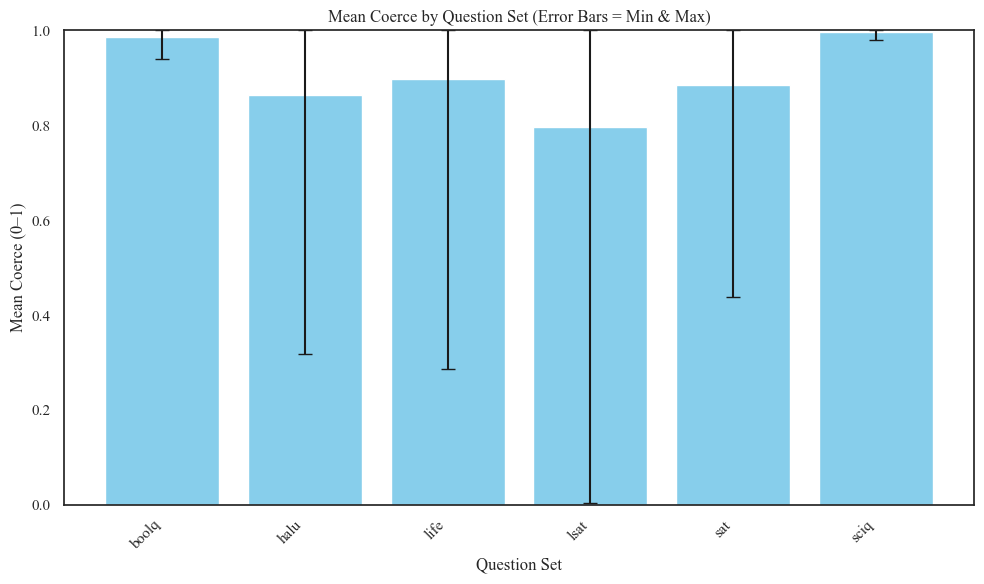

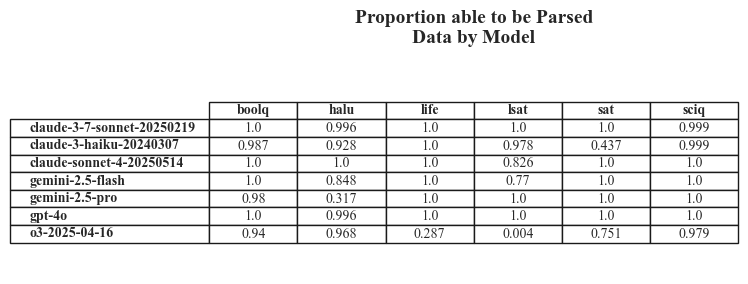

In [579]:
import pandas as pd
import os
from pathlib import Path

base_dir = Path("Parsed Results")  # change path if needed
rows = []

for provider in base_dir.iterdir():
    if provider.is_dir():
        for model_type in provider.iterdir():
            if model_type.is_dir():
                for csv_file in model_type.glob("*.csv"):
                    fname = csv_file.stem
                    question_set = fname.split("_")[0]
                    try:
                        df = pd.read_csv(csv_file)
                        if 'coerce' in df.columns:
                            mean_val = pd.to_numeric(df['coerce'], errors='coerce').mean()
                            rows.append({
                                "Model Type": model_type.name,
                                "Question Set": question_set,
                                "Mean Coerce": mean_val
                            })
                    except Exception as e:
                        print(f"Error reading {csv_file}: {e}")

results_df = pd.DataFrame(rows)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model Type",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)
# Calculate stats per question set
means = pivot_df.mean(axis=0)
mins = pivot_df.min(axis=0)
maxs = pivot_df.max(axis=0)

# Error bar values
error_lower = means - mins
error_upper = maxs - means

plt.figure(figsize=(10, 6))
plt.bar(means.index, means.values, yerr=[error_lower, error_upper], capsize=5, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Mean Coerce (0–1)")
plt.xlabel("Question Set")
plt.title("Mean Coerce by Question Set (Error Bars = Min & Max)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Create a clean table image
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
ax.set_title("Proportion able to be Parsed\nData by Model", fontweight='bold', fontsize=14, pad=20)
table = ax.table(
    cellText=pivot_df.round(3).values,
    colLabels=pivot_df.columns,
    rowLabels=pivot_df.index,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Make header bold
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')

plt.tight_layout()
plt.show()

##  Question Set Analysis

### BoolQ

In [310]:
# Get the correct answers from boolq_valid_formatted.csv
gold_path = 'Formatted Benchmarks\\boolq_valid_formatted.csv'
gold_df = pd.read_csv(gold_path)
gold_df

,Question,Correct Answer,Question ID
0,does ethanol take more energy make that produces,False,0
1,is house tax and property tax are same,True,1
2,is pain experienced in a missing body part or ...,True,2
3,is harry potter and the escape from gringotts ...,True,3
4,is there a difference between hydroxyzine hcl ...,True,4
...,...,...,...
3265,is manic depression the same as bi polar,True,3265
3266,was whiskey galore based on a true story,True,3266
3267,are there plants on the international space st...,True,3267
3268,does the hockey puck have to cross the line to...,True,3268


In [597]:
def get_ece(score: pd.Series, confidence: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    score = score.astype(bool)
    confidence = confidence.astype(float)

    # Bin edges and assignments
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            ece += (bin_count / total_count) * abs(bin_accuracy - bin_confidence)

    return ece

def sum_token_logprobs_boolq(old_df: pd.DataFrame):
    df = old_df.copy()
    truthy = ['True', 'true', 'TRUE', 'yes', 'Yes']
    falsey = ['False', 'false', 'FALSE', 'no', 'No']

    # Strip spaces for all t-columns
    t_cols = [f"t{i}" for i in range(1, 6)]
    p_cols = [f"t{i}_prob" for i in range(1, 6)]
    df[t_cols] = df[t_cols].apply(lambda col: col.str.strip())

    # Boolean masks for truthy/falsey per cell
    mask_truthy = df[t_cols].isin(truthy)
    mask_falsey = df[t_cols].isin(falsey)

    # Multiply masks by probability columns (automatically aligns column-wise)
    df["true_sum"] = (mask_truthy * df[p_cols].to_numpy()).sum(axis=1)
    df["false_sum"] = (mask_falsey * df[p_cols].to_numpy()).sum(axis=1)

    t_prob = df['true_sum'] / (df['false_sum'] + df['true_sum'])
    f_prob = df['false_sum'] / (df['false_sum'] + df['true_sum'])

    df['true_token_prob'] = t_prob
    df['false_token_prob'] = f_prob

    return df

    



#def plot_boolq_logprobs(res: pd.DataFrame, ans: pd.DataFrame):
    


,confidence,mean_score,count
0,0.20,0.333333,3
1,0.50,0.166667,12
2,0.60,0.500000,4
3,0.70,0.245614,57
4,0.80,0.331461,178
5,0.85,0.275000,40
6,0.90,0.338046,778
7,0.95,0.394848,2135
8,0.99,0.704545,44
9,1.00,0.611111,18


c:\Programs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Programs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Programs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Invalid token_type! Option must be "logprobs", "top100" or "None".


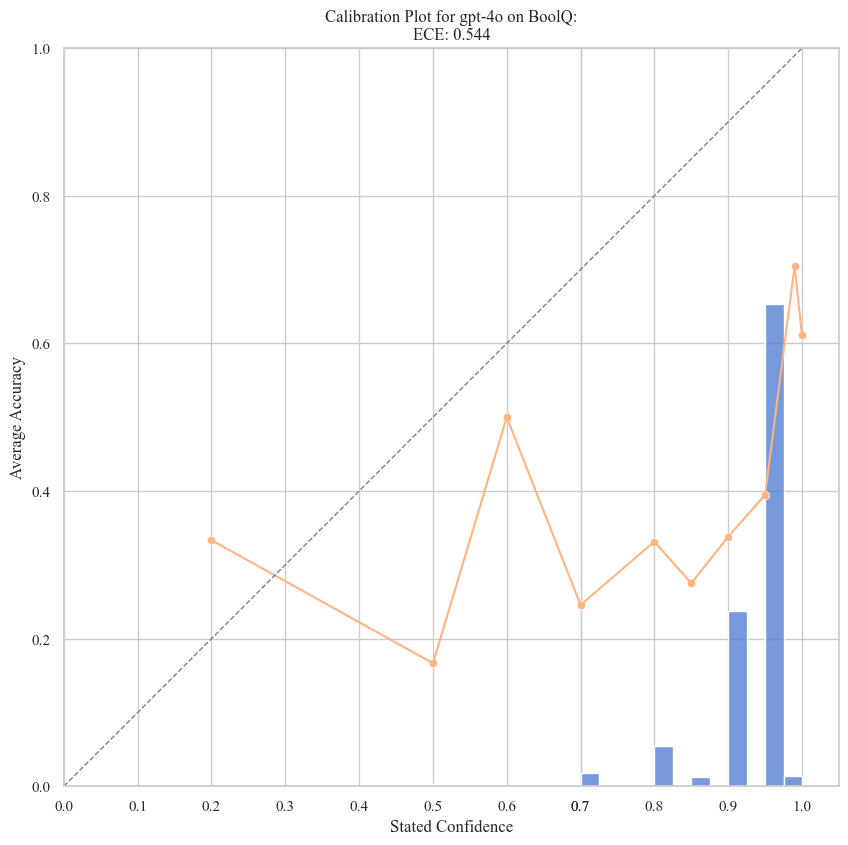

In [ ]:
import seaborn as sns
from typing import Literal
_TYPES = Literal['None', 'logprobs', 'top100']
def run_analysis_boolq(result_file_path, answer_df, token_type: _TYPES = None):
    model_name = result_file_path.split('\\')[2]
    ## Get Relevant Data
    result_df = pd.read_csv(result_file_path)

    response_series = result_df['answer'].str.lower == 'true' # Make into boolean
    stated_confidence_series = result_df['Confidence'].astype(float)
    answer_series = answer_df['Correct Answer']
    score_series = response_series == answer_series

    ece = get_ece(score_series, stated_confidence_series)
    #plot_calibration(score_series, stated_confidence_series, n_bins = 10)

    melt_df = melt_series(score_series, stated_confidence_series)

    combined_df = pd.DataFrame({'confidence': stated_confidence_series, 'score': score_series})

    # Color Palette
    color1 = sns.color_palette('muted')[0]
    color2 = sns.color_palette('pastel')[1]

    display(melt_df)
    sns.set_theme(font='Times New Roman', style= "whitegrid")
    
    sns.histplot(
        data=melt_df,
        x="confidence",
        weights=melt_df["count"] / melt_df["count"].sum(),   # use count values as weights
        bins=len(melt_df), # one bin per unique confidence
        edgecolor="white",
        #discrete= True,
        color= color1,
        binwidth= 0.025 #melt_df['confidence'].sort_values().diff().dropna().min()

    )
    p = sns.lineplot(combined_df, 
                 x = 'confidence', 
                 y = 'score',
                 #err_style= 'bars',
                 errorbar= None,
                 color = color2,


                )
    
    sns.scatterplot(melt_df, 
                 x = 'confidence', 
                 y = 'mean_score',
                 #size= 'count'
                 color = color2
                )
    

    # sns.barplot(
    #     data=melt_df,
    #     x="confidence",
    #     y= melt_df["count"] / melt_df["count"].sum(),
    #     color="skyblue",
    #     edgecolor="white"
    # )

    # Add 45-degree reference line
    p.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=1)

    # (Optional) improve readability
    p.set_xlim(0, 1.05)
    p.set_ylim(0, 1)
    p.set_aspect('equal', adjustable='box')  # Makes it a perfect square
    title = f'Calibration Plot for {model_name} on BoolQ:\nECE: {ece:.3f}'
    p.set_title(title)
    p.set_ylabel('Average Accuracy')
    p.set_xlabel('Stated Confidence')

    p.set_xticks([0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0])
    p.figure.set_size_inches(10, 10)

    # Summary Statistics:
    min_val_score = 0
    min_val_conf = 0

    max_val_score = 0
    max_val_conf = 0


    # Plot Token Plot:
    if token_type == 'logprobs':
        plot_boolq_logprobs(result_df, gold_df)
    elif token_type == 'top100':
        plot_boolq_top100()
    else:
        print('Invalid token_type! Option must be "logprobs", "top100" or "None".')





test_path ='Parsed Results\GPT\gpt-4o\\boolq_valid_gpt-4o.csv'

ece = run_analysis_boolq(test_path, gold_df, token_type= 'dog')

# #np.mean(scores)

# comparison_df = pd.DataFrame({
#     'res': res,
#     'ans': ans,
#     'match': res == ans
# })
# display(comparison_df)
# #res[0].dtype, ans[0].dtype

ece

In [598]:
test_df = pd.read_csv(test_path)
test_df_probs = sum_token_logprobs_boolq(test_df)
test_df_probs


,Question ID,content,answer,token_index,token,t1,t1_prob,t2,t2_prob,t3,...,t5_prob,correct_format,coerce,Reasoning,Answer,Confidence,true_sum,false_sum,true_token_prob,false_token_prob
0,0,"{\n ""Reasoning"": ""The energy balance of eth...",False,680.0,False,False,0.998142,True,1.700454e-03,It,...,5.412174e-06,True,True,The energy balance of ethanol production depen...,False,0.70,0.001700,9.981418e-01,0.001701,9.982993e-01
1,1,"{\n ""Reasoning"": ""House tax and property ta...",False,572.0,False,False,0.999663,True,3.353494e-04,false,...,2.101724e-07,True,True,House tax and property tax are often used inte...,False,0.80,0.000335,9.996633e-01,0.000335,9.996647e-01
2,2,"{\n ""Reasoning"": ""Pain experienced in a mis...",True,416.0,True,True,0.999997,Yes,2.902312e-06,False,...,1.818955e-09,True,True,Pain experienced in a missing body part is kno...,True,0.95,1.000000,4.139922e-08,1.000000,4.139922e-08
3,3,"{\n ""Reasoning"": ""Harry Potter and the Esca...",True,470.0,True,True,0.880602,False,1.191766e-01,Yes,...,2.139938e-05,True,True,Harry Potter and the Escape from Gringotts is ...,True,0.80,0.880711,1.191766e-01,0.880810,1.191900e-01
4,4,"{\n ""Reasoning"": ""Hydroxyzine is an antihis...",True,474.0,""":",""":",1.000000,""":""",3.224187e-08,"""",...,1.917172e-10,False,True,Hydroxyzine is an antihistamine used to treat ...,True,0.90,0.000000,0.000000e+00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,3265,"{\n ""Reasoning"": ""Manic depression is an ol...",True,401.0,True,True,0.999999,Yes,3.466324e-07,False,...,1.818962e-09,True,True,Manic depression is an older term that was use...,True,0.95,1.000000,9.931194e-08,1.000000,9.931195e-08
3266,3266,"{\n ""Reasoning"": ""The novel 'Whisky Galore'...",True,452.0,True,True,1.000000,Yes,3.466327e-07,true,...,5.905304e-10,True,True,The novel 'Whisky Galore' by Compton Mackenzie...,True,0.95,1.000000,4.944451e-09,1.000000,4.944451e-09
3267,3267,"{\n ""Reasoning"": ""The International Space S...",True,446.0,True,True,0.999999,Yes,5.715002e-07,False,...,2.172440e-10,True,True,The International Space Station (ISS) has been...,True,0.95,1.000000,1.818962e-09,1.000000,1.818962e-09
3268,3268,"{\n ""Reasoning"": ""In hockey, for a goal to ...",True,276.0,""":",""":",1.000000,""":""",1.186112e-08,"""",...,3.775135e-11,False,True,"In hockey, for a goal to be counted, the entir...",True,0.95,0.000000,0.000000e+00,NaN,NaN


In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_calibration(score: pd.Series,
                     confidence: pd.Series,
                     n_bins: int = 10,
                     show_hist: bool = True,
                     err_color: str = "gray"):
    """
    Plot a reliability (calibration) diagram with colored error bars.

    Parameters
    ----------
    score : pd.Series
        Ground truth correctness (bool or {0,1}).
    confidence : pd.Series
        Predicted probability for the chosen label, in [0,1].
    n_bins : int
        Number of equal-width bins over [0,1].
    show_hist : bool
        If True, show a histogram of confidence below the reliability curve.
    err_color : str
        Color for the error bars.
    """
    # Clean inputs
    s = score.astype(float).clip(0, 1)
    c = confidence.astype(float).clip(0, 1)
    mask = s.notna() & c.notna()
    s, c = s[mask], c[mask]

    # Bin edges and ids
    edges = np.linspace(0.0, 1.0, n_bins + 1)
    ids = np.digitize(c.values, edges, right=True)  # 1..n_bins
    ids = np.clip(ids, 1, n_bins)

    # Per-bin stats
    bin_df = (
        pd.DataFrame({"bin": ids, "score": s.values, "conf": c.values})
        .groupby("bin")
        .agg(
            bin_count=("score", "size"),
            bin_acc=("score", "mean"),
            bin_conf=("conf", "mean"),
        )
        .reindex(range(1, n_bins + 1))
        .fillna({"bin_count": 0, "bin_acc": np.nan, "bin_conf": np.nan})
    )
    bin_df["bin_left"] = edges[:-1]
    bin_df["bin_right"] = edges[1:]
    bin_df["bin_center"] = (bin_df["bin_left"] + bin_df["bin_right"]) / 2

    # Standard error of accuracy per bin
    bin_df["acc_sem"] = np.sqrt(
        (bin_df["bin_acc"] * (1 - bin_df["bin_acc"])) / bin_df["bin_count"]
    )
    bin_df.loc[bin_df["bin_count"] <= 1, "acc_sem"] = np.nan

    # ECE
    N = len(s)
    ece = (
        (bin_df["bin_count"] / N) * (bin_df["bin_acc"] - bin_df["bin_conf"]).abs()
    ).sum(skipna=True)

    # Plot
    if show_hist:
        fig = plt.figure(figsize=(6, 7))
        gs = fig.add_gridspec(2, 1, height_ratios=[2.5, 1.2], hspace=0.25)
        ax = fig.add_subplot(gs[0, 0])
        axh = fig.add_subplot(gs[1, 0])
    else:
        fig, ax = plt.subplots(figsize=(6, 5))

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")

    # Plot line & points separately from error bars
    valid = bin_df["bin_count"] > 0
    ax.plot(
        bin_df.loc[valid, "bin_conf"],
        bin_df.loc[valid, "bin_acc"],
        marker="o",
        linestyle="-",
        color="blue",
        label="Empirical accuracy"
    )

    # Plot error bars in a separate color
    ax.errorbar(
        bin_df.loc[valid, "bin_conf"],
        bin_df.loc[valid, "bin_acc"],
        yerr=bin_df.loc[valid, "acc_sem"],
        fmt="none",               # No marker/line
        ecolor=err_color,         # Error bar color
        elinewidth=1.5,
        capsize=4
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Mean confidence (per bin)")
    ax.set_ylabel("Empirical accuracy (per bin)")
    ax.set_title(f"Calibration Plot (ECE = {ece:.4f}, bins={n_bins})")
    ax.legend()

    # Optional histogram
    if show_hist:
        axh.hist(c.values, bins=edges, align="mid", edgecolor="black")
        axh.set_xlim(0, 1)
        axh.set_xlabel("Confidence")
        axh.set_ylabel("Count")

    return fig, ax, bin_df, ece


In [379]:


def melt_series(score: pd.Series, confidence: pd.Series):
    df = pd.DataFrame({'confidence': confidence, 'score': score})

    # Group by confidence and aggregate
    melt_df = df.groupby('confidence').agg(
        mean_score=('score', 'mean'),
        count=('score', 'size')
    ).reset_index()
    return melt_df